# Bricks and Board Code Challenge

## The Problem

I am in an open field with an endless supply of bricks. My hobby is stacking bricks up in equally-spaced columns of random heights.

I choose the number of columns randomly. It could be 10, or 27, or 63,972,152. I'm a patient guy and I like columns of bricks.

Each time, when I'm done, I lay a wooden board on top of the columns of bricks. I have access to a huge variety of board lengths, so I always choose one that starts exactly above the top of the first column, and stretches to exactly above the top of the last column, regardless of its angle.

It doesn't always touch the tops of those columns, of course. I chose the column heights randomly. Maybe on some occasions it rests on those, but in other cases it comes to rest on bricks anywhere in between them. It all depends on the height of the columns and where gravity dictates the board will sit. But in any case, these bricks are rough enough that the board never slides off, even at severe slopes.

Your job is to figure out, given the number of bricks in each column, the slope and y-intercept of my board.

Columns of bricks are provided in an array, where the array index is "x" and the value is "y".

## Forget The High School Line Formula Stuff?

Me too. Here's a quick refresher:

A straight line is defined by the formula y = mx + b:

* **x:** the column number, starting from 0
* **y:** the height of the board, in bricks, at that column
* **m:** the slope of the board, or "rise over run": take two points the board is touching, x1,y1 and x2,y2, and the slope is (y2 - y1) / (x2 - x1).
* **b:** y-intercept: how high the board is from the ground, in bricks, at column 0

> _Important Note:_ For simplicity, let's ignore the fact that any angled board will have a slightly varying height over the width of a stack of bricks. The board's height (y) when it's touching a brick is equal to the number of bricks beneath it.

## Here's an example

`[2, 14, 8, 94, 300, 210, 200, 99, 14, 12]`

Laying a board on top of this, it comes to rest on x=4 y=300, and x=6 y=200. ("Not 300 and 210?!" Some of you are thinking? Nope, if it rested on 210, the slope would be too severe that it would fall BELOW the top of the 200 stack. For real, check the math. This problem isn't as simple as it sounds.)

Slope is rise (y2 - y1) divided by run (x2 - x1). So: (200 - 300) / (6 - 4) = -50.

y-intercept can then be found by plugging the slope into the y=mx+b line equation for either of those resting points above. I'll pick x=6 y=200:

```
200 = -50 * 6 + b
200 = -300 + b
b = 200 - -300
b = 500
```

So with those stacks, slope is **-50** and y-intercept is **500**.

Write me a function that outputs those two variables given any input array. No gravity-defying boards!

Starting with 30 columns, midpoint 15, cursors [14, 15]


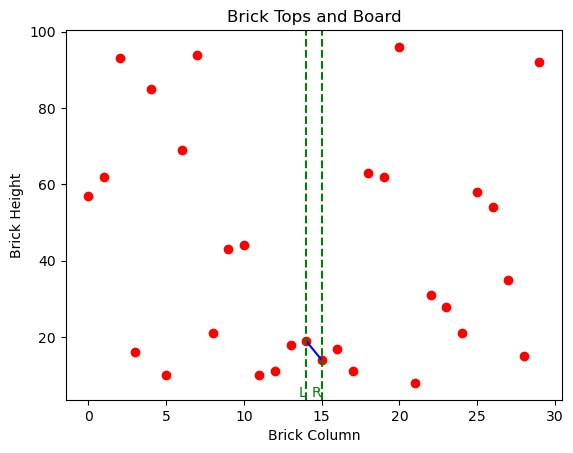

Right side changed
Rechecking left side
No change


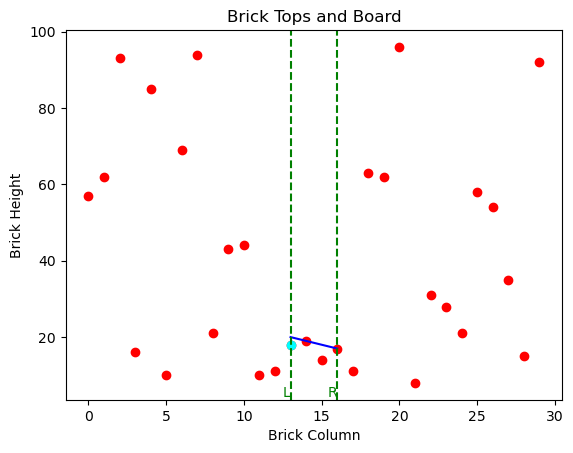

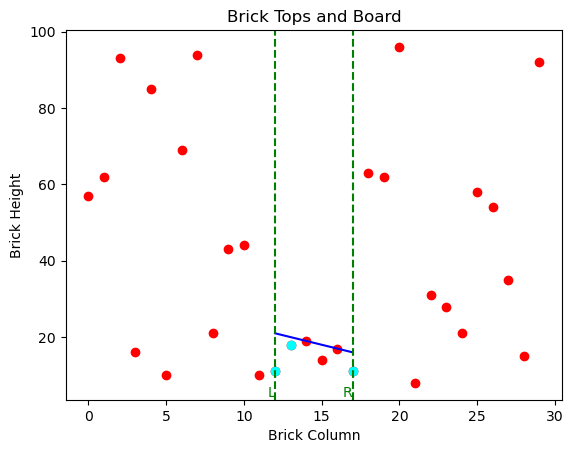

Right side changed
Rechecking left side
Left side changed


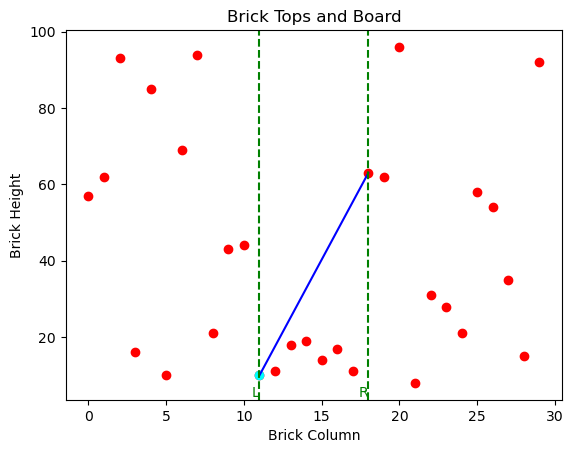

Left side changed


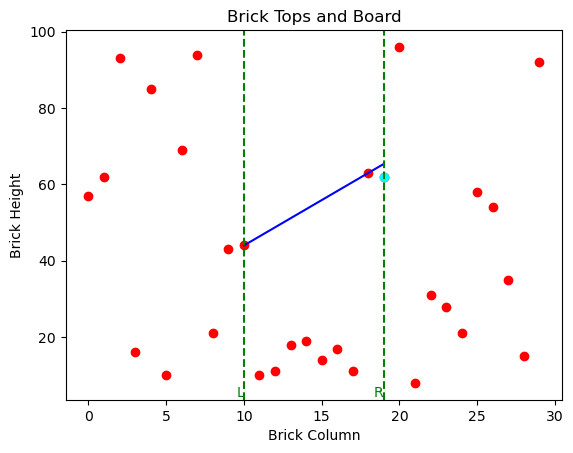

Left side changed
Right side changed


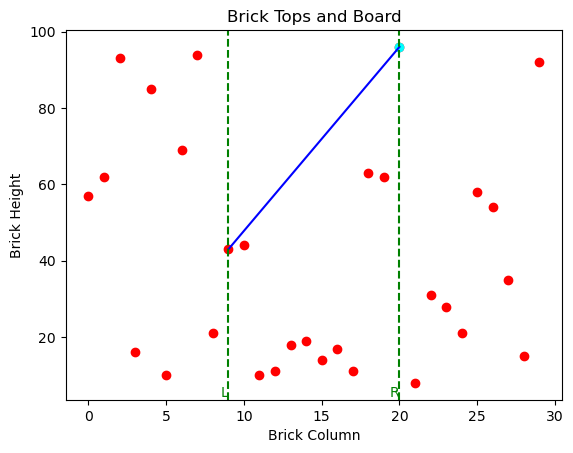

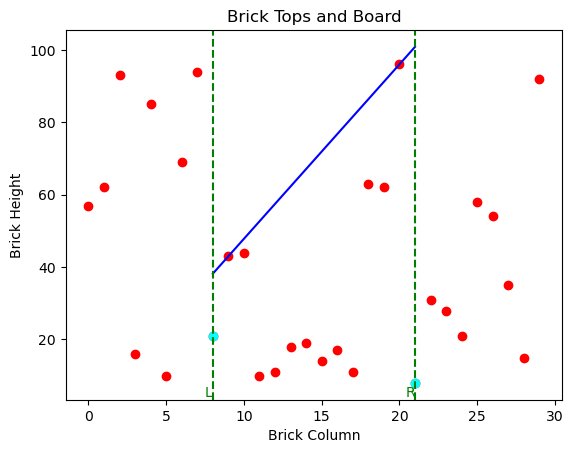

Left side changed


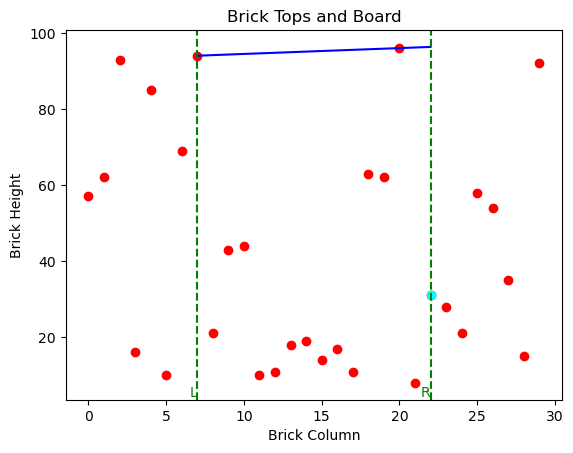

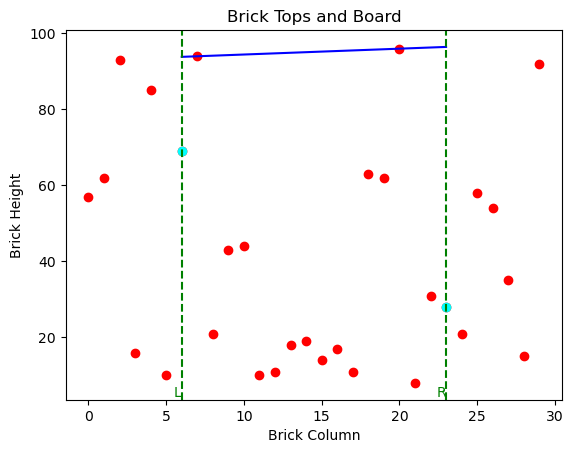

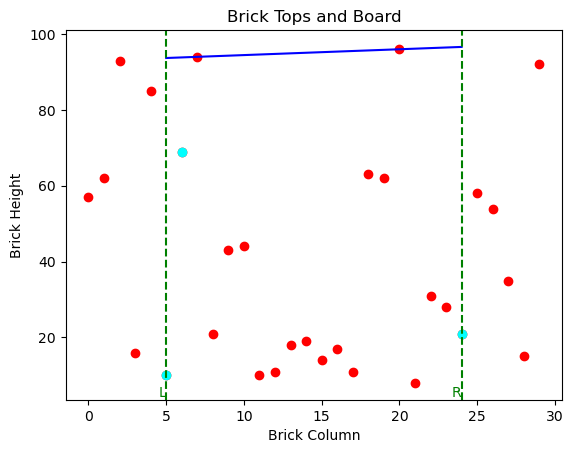

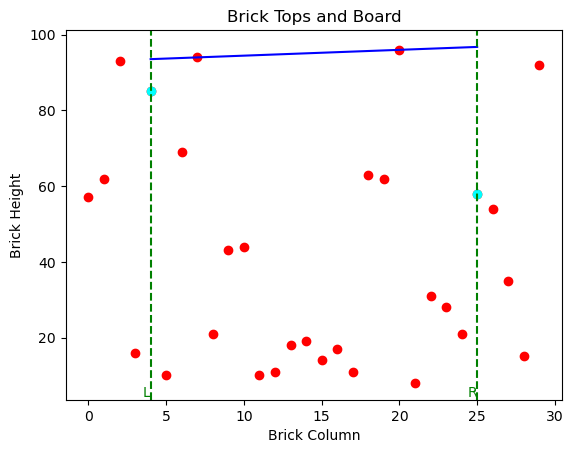

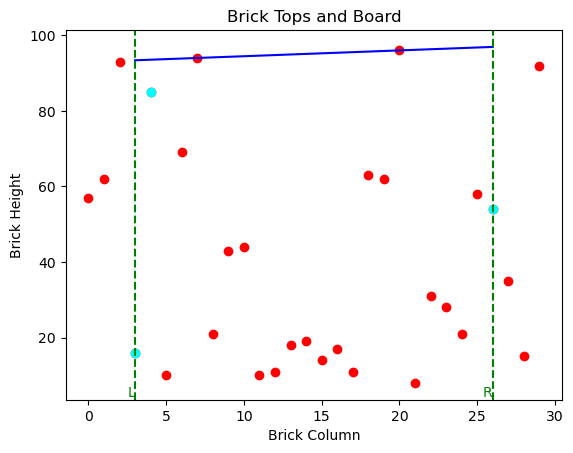

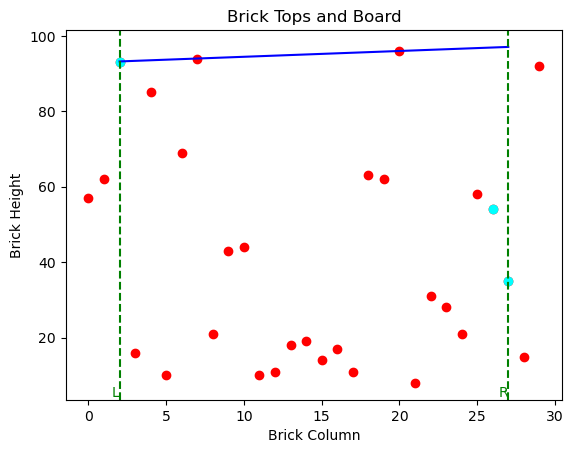

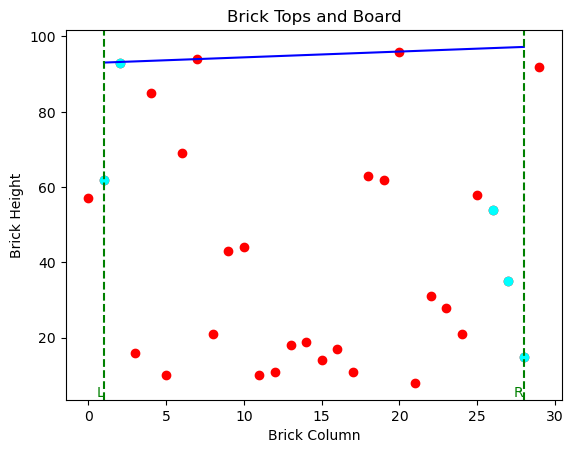

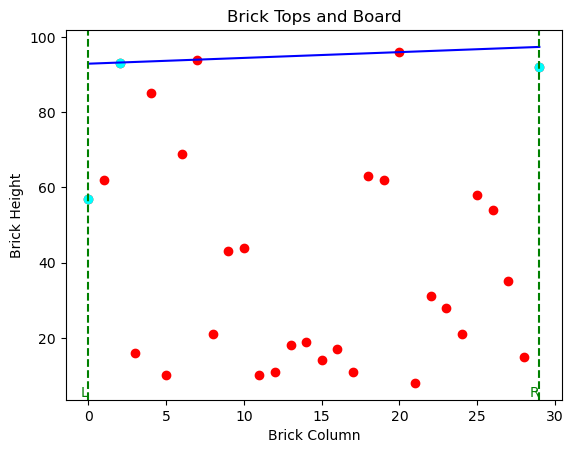

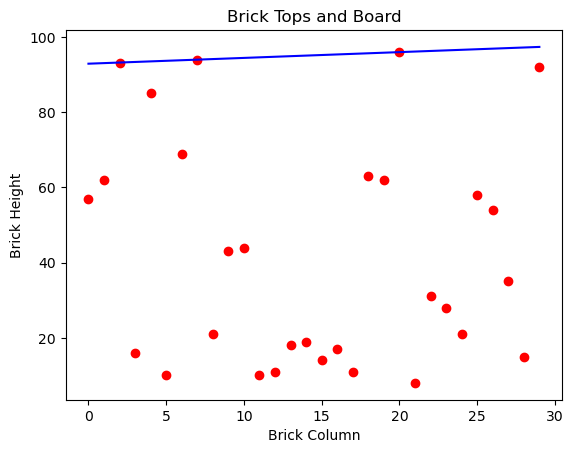

Data: [57, 62, 93, 16, 85, 10, 69, 94, 21, 43, 44, 10, 11, 18, 19, 14, 17, 11, 63, 62, 96, 8, 31, 28, 21, 58, 54, 35, 15, 92]
Slope: 0.15384615384615385
Y-Intercept: 92.92307692307692


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
import json

LEFT = 0
RIGHT = 1
STEP = [-1, 1]

# Function to generate an array of random integers
def generate_random_array(data_length = 30, max_value = 100):
    return np.random.randint(0, max_value, data_length)

# Function to calculate the slope and y-intercept
# Solution concept:
#
# This is the same solution as the "Tom_Simple" version, with one key difference:
# Each side of the line tracks the "pivot points": Points that are underneath
# the current line, but which are possible for a future line to touch if the
# opposite side of the line is raised higher. Now, instead of having to scan
# every point between the touchpoint and the cursor when the opposite side
# of the line is raised, we only need to check the pivots -- statistically
# unlikely to ever be more than 4 points.
#
# Here's how it works: Every time the cursor visits a new point, it draws an
# imaginary line between that point and that side's touchpoint. Any pivot that's
# under that line gets removed from the array of pivots, because those points
# become impossible to reach by the board. We then append the cursor to the pivots.
# Any time we get a new touchpoint, we delete any pivots between the touchpoint
# and the center of the board.
#
# This solution reduces the number of checks required every time we alter the line,
# but due to the testing of the existing pivots every time the cursors move, this
# is actually far less performant than Tom_Simple.
def calculate_slope_intercept(arr, debug_mode=False):
    if len(arr) < 1:
        raise ValueError("Array must have at least one element")

    def get_line(x1, x2):
        # If the Xes are the same, it's a horizontal line at Y
        if x1 == x2: return 0, arr[x1]
        x_min = min(x1, x2)
        x_max = max(x1, x2)
        slope = (arr[x_max] - arr[x_min]) / (x_max - x_min)
        y_intercept = arr[x_min] - slope * x_min
        return slope, y_intercept

    # This is a middle-out algorithm. Find the middle of the board, and
    # initialize a left-moving cursor and a right-moving cursor there.
    # These cursors point to the same columns if there's an odd number
    # of columns, or to the two adjacent middle columns when it's even.
    #
    # Right now, these are the only two brick columns we've "seen", so we
    # consider these the touch points and calculate the line that passes
    # through them. The line is horizontal if there's just one middle column.
    midpoint = int(len(arr) / 2)
    cursors = [midpoint - 1, midpoint] if len(arr) % 2 == 0 else [math.floor(midpoint), math.ceil(midpoint)]
    touches = [cursors[0], cursors[1]]
    pivots = [[], []]
    slope, y_intercept = get_line(touches[0], touches[1])
    if debug_mode: print(f"Starting with {len(arr)} columns, midpoint {midpoint}, cursors {cursors}")
    if debug_mode: plot_data_with_line(arr, slope, y_intercept, cursors)

    def point_beneath_line(x, slope, y_intercept):
        line_height = slope * x + y_intercept
        return arr[x] <= line_height

    # Pivots are possible future touchpoints, depending on how the line's
    # slope changes. This function deletes pivots when new values at the cursor
    # make them impossible to serve as touchpoints under any condition.
    def update_pivots(side):
        nonlocal pivots
        # Short-circuit if the last pivot is equal to the cursor already
        if len(pivots[side]) > 0 and pivots[side][-1] == cursors[side]: return
        # Get a line from the cursor to the touchpoint
        p_slope, p_intercept = get_line(cursors[side], touches[side])
        # Eliminate all pivots beneath that line
        def is_above(x):
            return arr[x] > p_slope * x + p_intercept
        pivots[side] = list(filter(is_above, pivots[side]))
        # Add the cursor to the pivots
        pivots[side].append(cursors[side])

    def test_side(side, scan_pivots = False):
        nonlocal slope, y_intercept, touches, pivots
        orig_touch = touches[side]
        update_pivots(side)
        if scan_pivots:
            # We need to scan every pivot between this side's touch and
            # the cursor. When we find a point over the line, it becomes
            # a touch and we recalculate the line.
            used_pivot_idx = None
            for idx, pivot in enumerate(pivots[side]):
                if not point_beneath_line(pivot, slope, y_intercept):
                    touches[side] = pivot
                    used_pivot_idx = idx
                    slope, y_intercept = get_line(touches[0], touches[1])
            if used_pivot_idx is not None:
                pivots[side] = pivots[side][used_pivot_idx:]
        elif not point_beneath_line(cursors[side], slope, y_intercept):
            # No need to scan. Just make the cursor a touch point.
            touches[side] = cursors[side]
            pivots[side] = []
            slope, y_intercept = get_line(touches[0], touches[1])
        # Return True if the line changed
        return touches[side] != orig_touch

    # MAIN SOLUTION LOOP
    while cursors[LEFT] > 0:
        # On each loop, we move the cursors one step toward the ends
        cursors[LEFT] -= 1
        cursors[RIGHT] += 1
        # Test the left side first
        left_changed = test_side(LEFT)
        if debug_mode and left_changed: print("Left side changed")
        # Now test the right side. Check each pivot if the right end of
        # the line is lower due to the left side being raised
        right_changed = test_side(RIGHT, left_changed)
        if debug_mode and right_changed: print("Right side changed")
        # If the left side didn't change before and we raised the right side,
        # the left side is now lower than it used to be. Scan the pivots.
        if not left_changed and right_changed:
            if debug_mode: print("Rechecking left side")
            left_changed = test_side(LEFT, True)
            if debug_mode: print("Left side changed" if left_changed else "No change")
        # Plot progress
        if debug_mode: plot_data_with_line(arr, slope, y_intercept, cursors, pivots)

    return slope, y_intercept

# Function to plot the data and the line
def plot_data_with_line(arr, slope, y_intercept, cursors = None, pivots = None):
    x = np.arange(len(arr))
    y = arr
    
    plt.scatter(x, y, color='red', label='Brick Column Tops')

    # Highlight the pivots
    if pivots is not None:
        for pivot in pivots[0] + pivots[1]:
            plt.scatter(pivot, arr[pivot], color='cyan', label='Pivot')
    
    if cursors is not None:
        line_x = np.arange(cursors[0], cursors[1] + 1)
    else:
        line_x = x
    line_y = slope * line_x + y_intercept
    plt.plot(line_x, line_y, color='blue', label='Board')

    if cursors is not None:
        plt.axvline(x=cursors[0], color='green', linestyle='--', label='Cursor L')
        plt.text(cursors[0], plt.ylim()[0], 'L', color='green', verticalalignment='bottom', horizontalalignment='right')
        plt.axvline(x=cursors[1], color='green', linestyle='--', label='Cursor R')
        plt.text(cursors[1], plt.ylim()[0], 'R', color='green', verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Brick Column')
    plt.ylabel('Brick Height')
    plt.title('Brick Tops and Board')
    #plt.legend()
    plt.show()

# Calling the functions to visualize the output
data_length = 30
max_value = 100
random_array = generate_random_array(data_length, max_value)
slope, y_intercept = calculate_slope_intercept(random_array, True)
plot_data_with_line(random_array, slope, y_intercept)
print("Data:", json.dumps(random_array.tolist()))
print("Slope:", slope)
print("Y-Intercept:", y_intercept)

Text(0, 0.5, 'Time Taken')

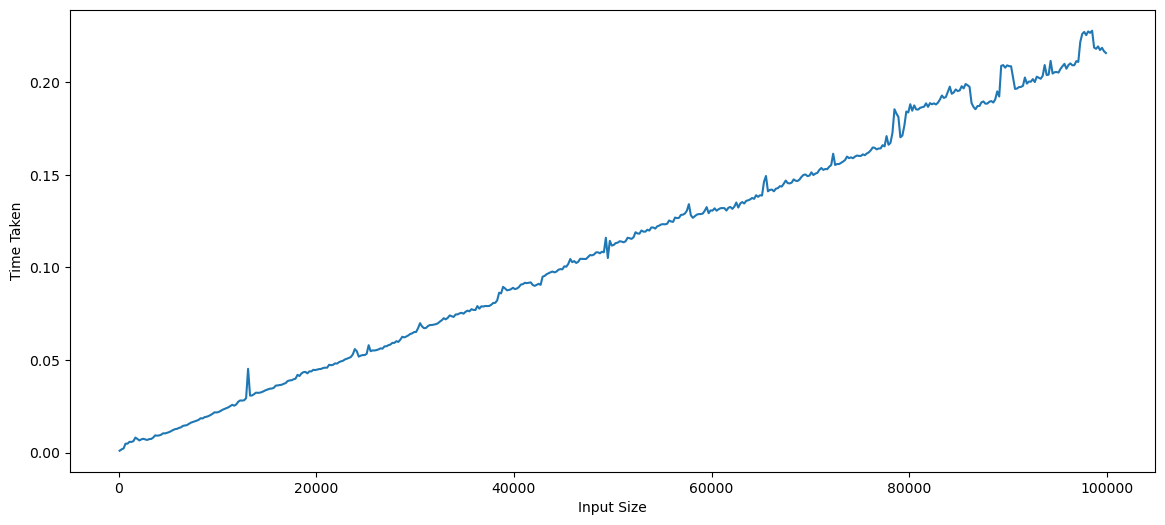

In [8]:
import time

input_sizes = range(100, 100000, 200)
samples = 1
times = []
for n in input_sizes:
    total = 0
    for j in range(samples):
        start_time = time.time()
        random_array = generate_random_array(n)
        slope, y_intercept = calculate_slope_intercept(random_array)
        end_time = time.time()
        total += (end_time - start_time)
    times.append(total / samples)

plt.figure(figsize=(14, 6))
plt.plot(input_sizes, times)
plt.xlabel('Input Size')
plt.ylabel('Time Taken')